# House prices
by Vladyslav Chekryzhov, Anton Zubochenko and Elizaveta Lavrenova

## 0. Импорт библиотек

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 1. Импорт данных

In [2]:
#train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
#test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Saving train.csv to train.csv
Saving test.csv to test.csv
User uploaded file "train.csv" with length 460676 bytes
User uploaded file "test.csv" with length 451405 bytes


In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2. Исследование целевой переменной

In [4]:
#общая информация
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [5]:
#параметры распределения
print(train['SalePrice'].skew())
print(train['SalePrice'].kurt())

1.8828757597682129
6.536281860064529


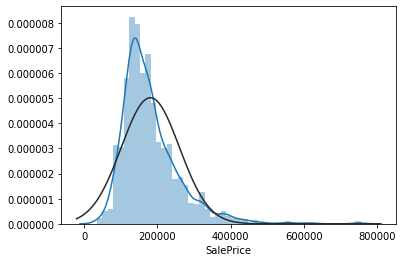

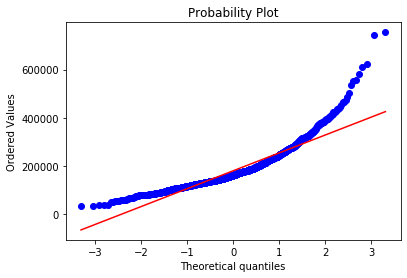

In [6]:
#строим распределение
sns.distplot(train['SalePrice'], fit=norm)

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

Распределение переменной отличается от нормального, оно не совсем симметрично и имеет длинный правый хвост

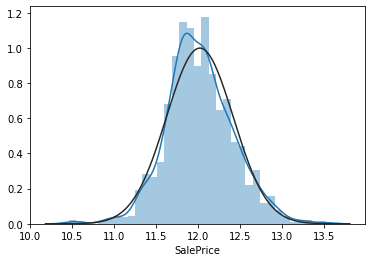

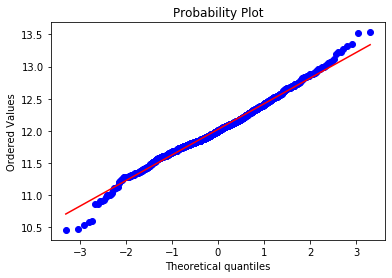

In [7]:
train['oldSalePrice'] = train['SalePrice'].copy()
#применим логорифмирование к целевой переменной
train['SalePrice'] = np.log(train['SalePrice'])
sns.distplot(train['SalePrice'], fit=norm)

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

Распределение стало близким к нормальному

## 3. Корреляция 

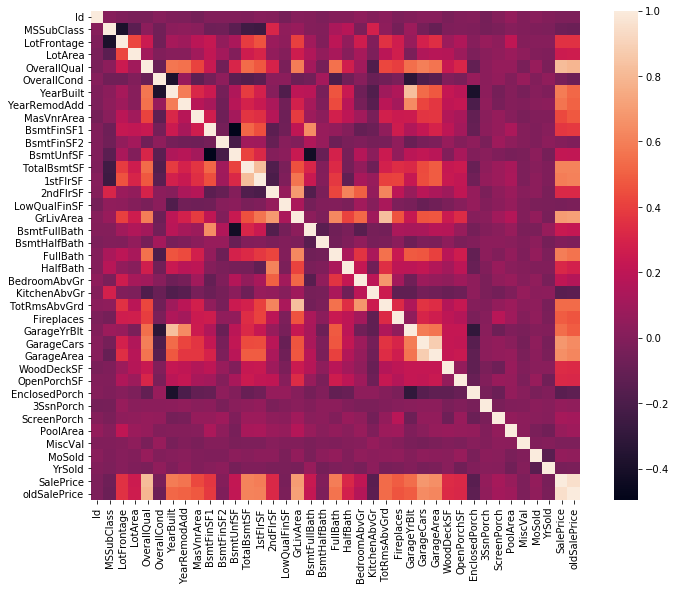

In [0]:
#полная матрица корреляции
fig, ax = plt.subplots(figsize=(12,9))
sns.heatmap(train.corr(),square=True);

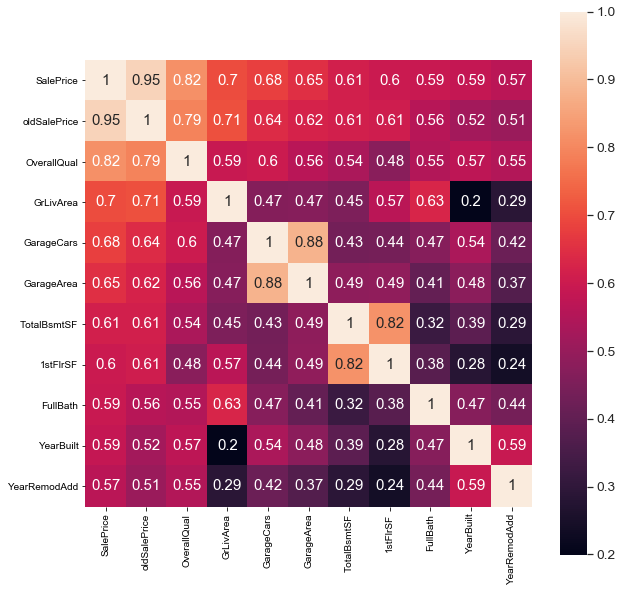

In [0]:
#топ-10 наиболее коррелирующих переменных
cols = train.corr().nlargest(11, 'SalePrice').index
plt.subplots(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(train[cols].corr(),square=True, annot=True);

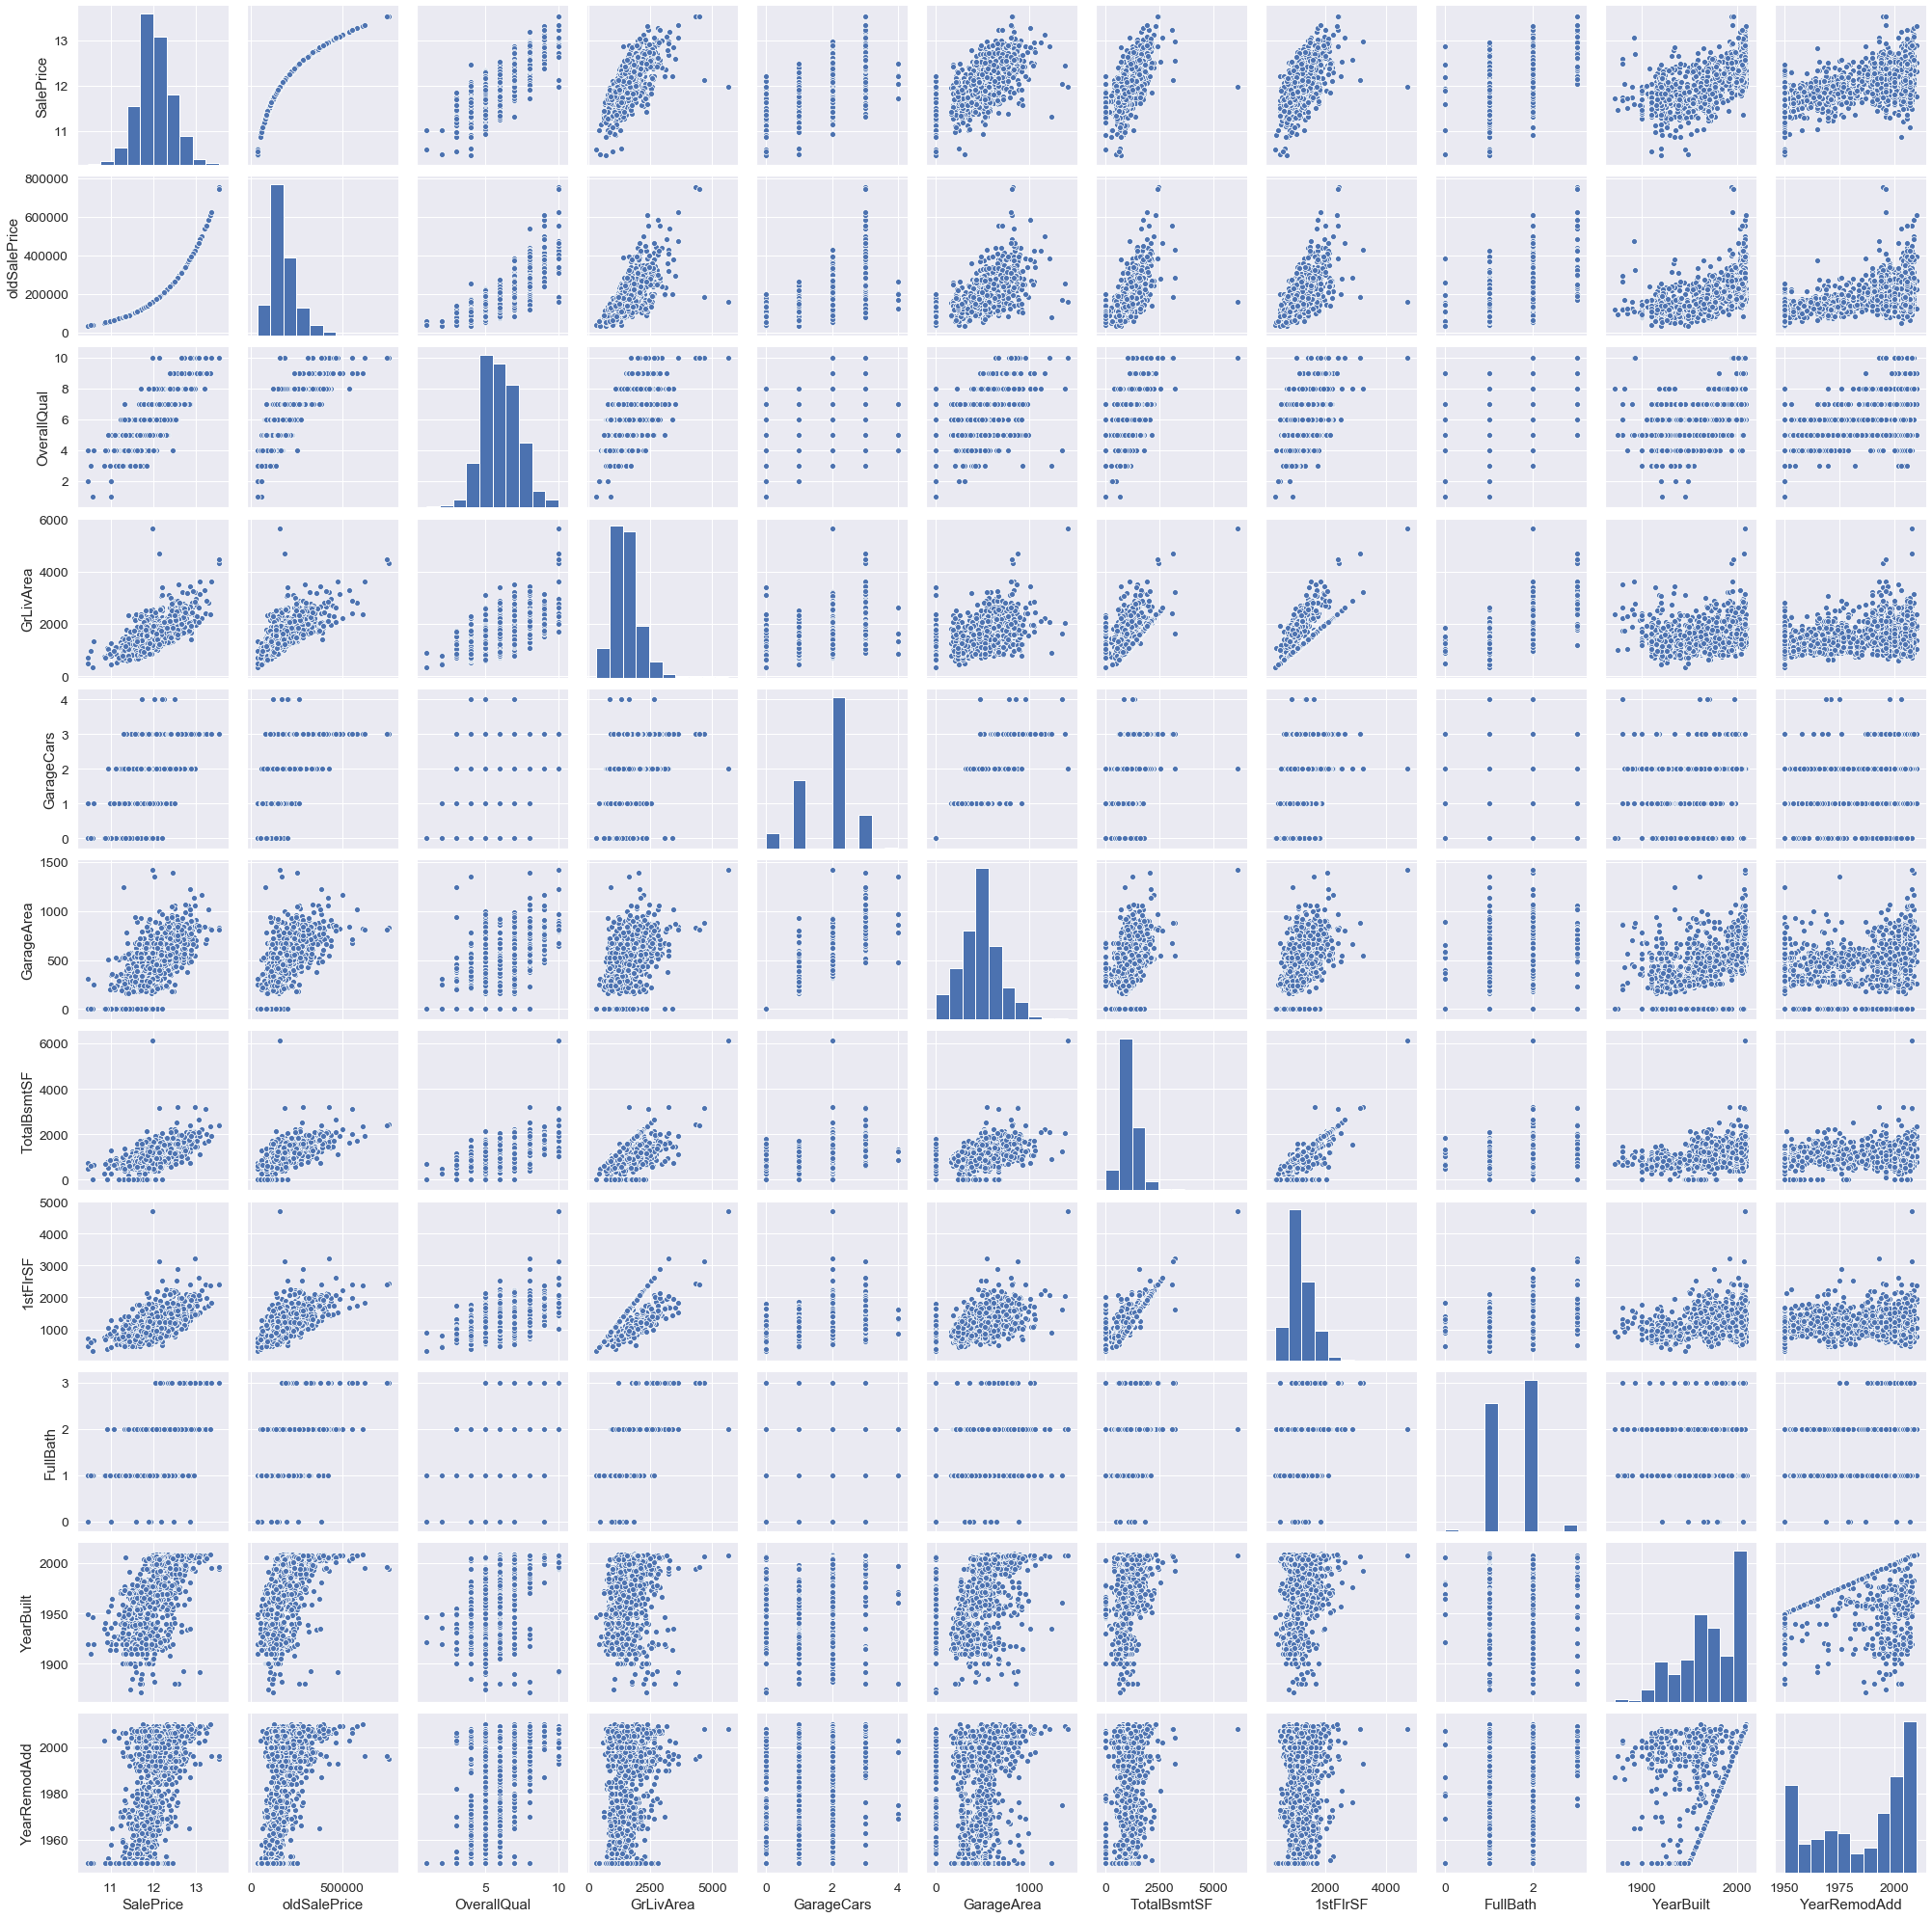

In [0]:
# изучим графики для более детального понимания 
sns.pairplot(train[cols]);

Рассмотрим каждую из переменных более подробно и поработаем с выбросами

1. Площадь

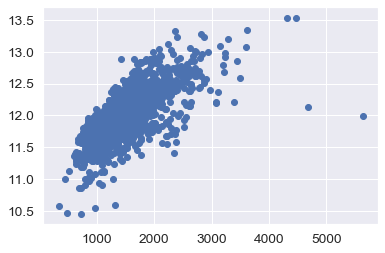

In [0]:
var = 'GrLivArea'
plt.scatter(x=train[var], y=train['SalePrice']);

In [0]:
train[train['GrLivArea'] > 4500].index

Int64Index([523, 1298], dtype='int64')

2. Площадь гаража

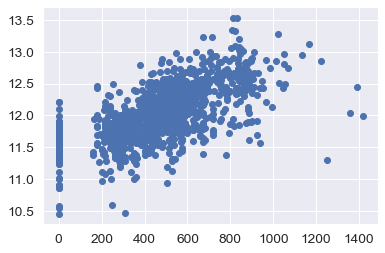

In [0]:
var = 'GarageArea'
plt.scatter(x=train[var], y=train['SalePrice']);

In [0]:
train[train['GarageArea'] > 1220].index

Int64Index([581, 1061, 1190, 1298], dtype='int64')

3. Площадь подвала

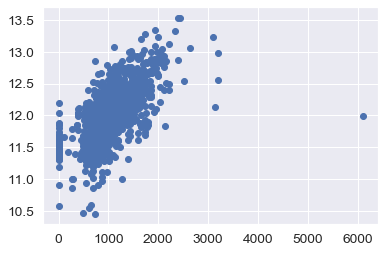

In [0]:
var = 'TotalBsmtSF'
plt.scatter(x=train[var], y=train['SalePrice']);

In [0]:
train[train['TotalBsmtSF'] > 5000].index

Int64Index([1298], dtype='int64')

4. Площадь первого этажа

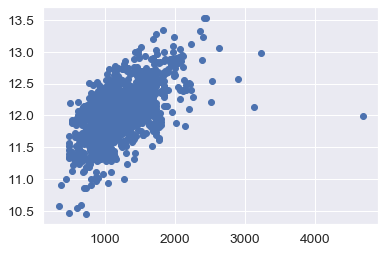

In [0]:
var = '1stFlrSF'
plt.scatter(x=train[var], y=train['SalePrice']);

In [0]:
train[train['TotalBsmtSF'] > 4000].index

Int64Index([1298], dtype='int64')

5. Качество жилья

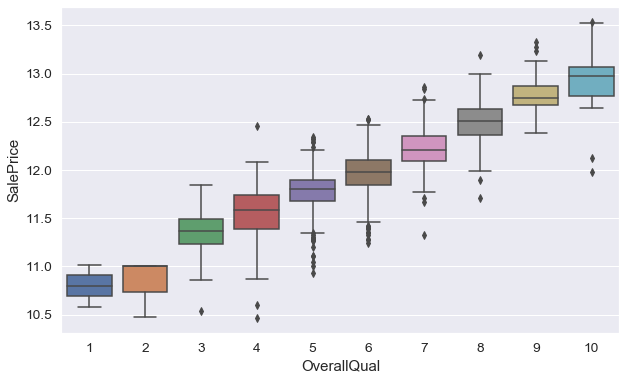

In [0]:
var = 'OverallQual'
plt.subplots(figsize=(10,6))
sns.boxplot(x=train[var], y=train['SalePrice']);

6. Год постройки

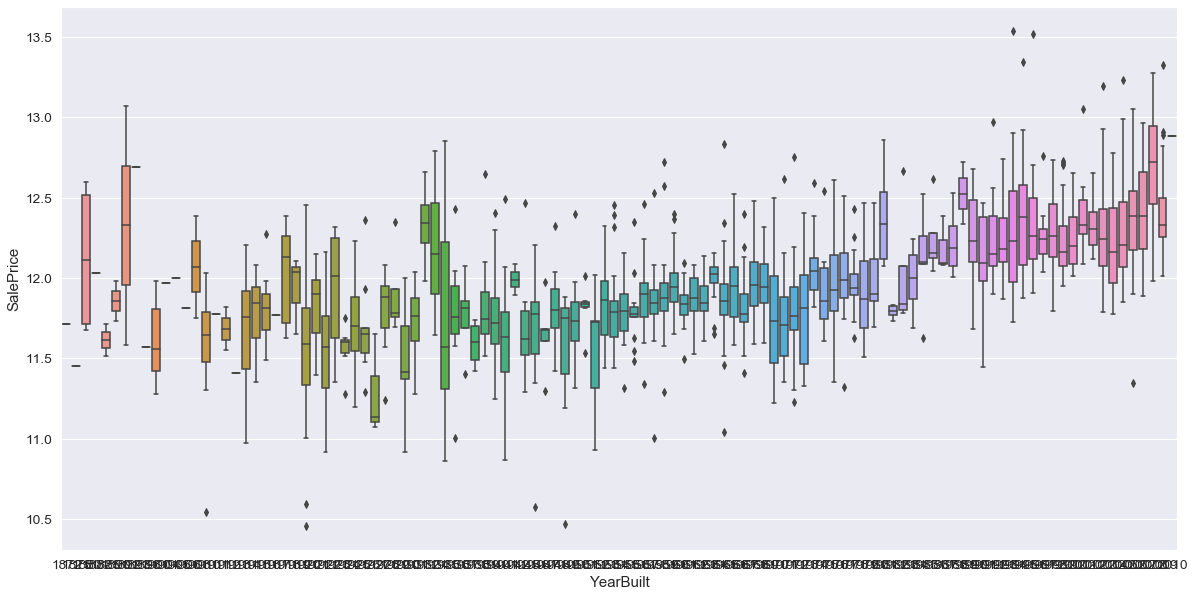

In [0]:
var = 'YearBuilt'
plt.subplots(figsize=(20,10))
sns.boxplot(x=train[var], y=train['SalePrice']);

## 4. Подготовка данных для анализа

In [0]:
# удаляем строки с выбросами
train = train.drop([523, 581, 1061, 1190, 1298])

In [0]:
train.reset_index(drop=True, inplace=True)

In [0]:
y_train_old = train['oldSalePrice'].reset_index(drop=True)
y_train = train['SalePrice'].reset_index(drop=True)
train = train.drop(['oldSalePrice'], axis=1)
train = train.drop(['SalePrice'], axis=1)

In [0]:
test_id = test['Id'].reset_index(drop=True)

In [0]:
#Delete ID
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [13]:
#concatenate train and test
all_features = pd.concat((train,test)).reset_index(drop=True)
all_features.shape

(2914, 79)

## 5. Работа с пропущенными значениями

In [14]:
all_features.isnull().sum().sort_values(ascending=False).head(5)

PoolQC         2905
MiscFeature    2810
Alley          2716
Fence          2343
FireplaceQu    1419
dtype: int64

In [15]:
# missing values
total = all_features.isnull().sum().sort_values(ascending=False)
percent = (all_features.isnull().sum()/all_features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent], axis=1, keys=['Total','Percent'])
missing_data.head(5)

,Total,Percent
PoolQC,2905,0.996911
MiscFeature,2810,0.964310
Alley,2716,0.932052
Fence,2343,0.804049
FireplaceQu,1419,0.486960


In [0]:
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].apply(str)
all_features['MoSold'] = all_features['MoSold'].apply(str)

In [0]:

common_vars = ['Exterior1st','Exterior2nd','SaleType','Electrical','KitchenQual']
for var in common_vars:
    all_features[var] = all_features[var].fillna(all_features[var].mode()[0])

all_features['MSZoning'] = all_features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

all_features['Functional'] = all_features['Functional'].fillna('Typ')

In [0]:
col_str = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual',
            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"PoolQC"
           ,'Alley','Fence','MiscFeature','FireplaceQu','MasVnrType','Utilities']
for col in col_str:
    all_features[col] = all_features[col].fillna('None')

In [0]:
col_num = ['GarageYrBlt','GarageArea','GarageCars','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BsmtUnfSF','TotalBsmtSF']
for col in col_num:
    all_features[col] = all_features[col].fillna(0)
    
all_features['LotFrontage'] = all_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [20]:
all_features.isnull().sum().sort_values(ascending=False).head(5)

SaleCondition    0
Foundation       0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
dtype: int64

## 6. Работа с числовыми переменными

In [0]:
num_features = all_features.select_dtypes(exclude='object').columns

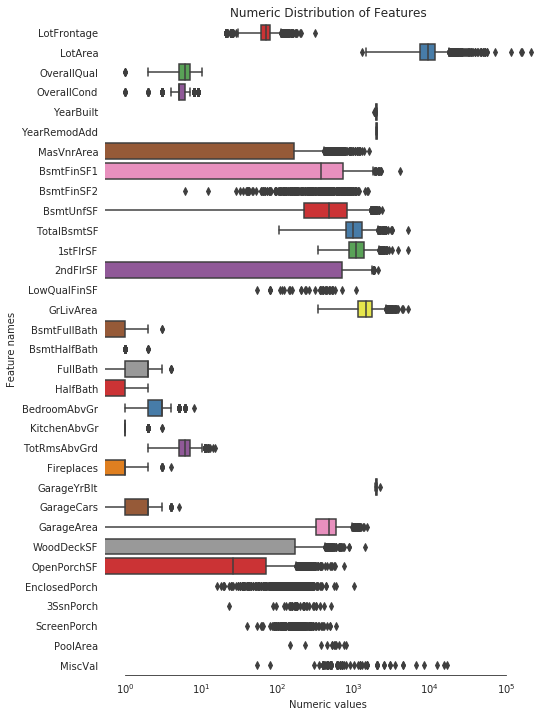

In [22]:
#посмотрим на распределения переменных
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 12))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[num_features], orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [23]:
#определим наименее симметричные распределения
skewness = all_features[num_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skewness = skewness[abs(skewness) > 0.5]

print("There are {} numerical features with Skew > 0.5 :".format(high_skewness.shape[0]))
high_skewness.sort_values(ascending=False)

There are 27 numerical features with Skew > 0.5 :


MiscVal          21.938142
PoolArea         17.679480
LotArea          13.161619
LowQualFinSF     12.078203
3SsnPorch        11.366100
KitchenAbvGr      4.297992
BsmtFinSF2        4.142042
EnclosedPorch     4.000022
ScreenPorch       3.942711
BsmtHalfBath      3.927598
MasVnrArea        2.623104
OpenPorchSF       2.529011
WoodDeckSF        1.846543
1stFlrSF          1.259551
LotFrontage       1.105402
GrLivArea         1.070000
BsmtFinSF1        0.981287
BsmtUnfSF         0.915658
2ndFlrSF          0.860006
TotRmsAbvGrd      0.750053
Fireplaces        0.725957
HalfBath          0.696629
TotalBsmtSF       0.671599
BsmtFullBath      0.622273
OverallCond       0.568791
YearBuilt        -0.600161
GarageYrBlt      -3.902257
dtype: float64

In [24]:
high_skewness.index

Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', '1stFlrSF',
       'LotFrontage', 'GrLivArea', 'BsmtFinSF1', 'BsmtUnfSF', '2ndFlrSF',
       'TotRmsAbvGrd', 'Fireplaces', 'HalfBath', 'TotalBsmtSF', 'BsmtFullBath',
       'OverallCond', 'YearBuilt', 'GarageYrBlt'],
      dtype='object')

In [0]:
#применим преобразование бокса-кокса к переменным с несимметричным распределением
from scipy.special import boxcox1p
skewed_features = high_skewness.index
for feat in skewed_features:
    all_features[feat] = boxcox1p(all_features[feat], boxcox_normmax(all_features[feat] + 1))

In [26]:
new_skewness = all_features[num_features].apply(lambda x: skew(x)).sort_values(ascending=False)
new_high_skewness = new_skewness[abs(new_skewness) > 0.5]
print("There are {} skewed numerical features after Box Cox transform".format(new_high_skewness.shape[0]))
print("Mean skewnees: {}".format(np.mean(new_high_skewness)))
new_high_skewness.sort_values(ascending=False)

There are 17 skewed numerical features after Box Cox transform
Mean skewnees: 3.50036592802739


PoolArea         15.586978
3SsnPorch         8.857393
LowQualFinSF      8.488132
MiscVal           5.262358
BsmtHalfBath      3.777145
KitchenAbvGr      3.775995
ScreenPorch       3.150711
BsmtFinSF2        2.576620
EnclosedPorch     2.147595
MasVnrArea        0.978347
2ndFlrSF          0.894319
WoodDeckSF        0.785294
HalfBath          0.732566
GarageYrBlt       0.701210
OpenPorchSF       0.621476
BsmtFullBath      0.616462
Fireplaces        0.553621
dtype: float64

## 7. Feature engineering

In [0]:
# создаем более значимые комбинации факторов 
all_features['TotalSF']=all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']

all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))

all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])

# создаем новые бинарные признаки вместо числовых
all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


all_features = all_features.drop(['MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'BsmtFinSF1','2ndFlrSF'], axis=1)

## 8. Кодирование категориальных переменных

In [30]:
all_features.shape

(2914, 81)

In [29]:
all_features_dummy = pd.get_dummies(all_features).reset_index(drop=True)
all_features_dummy.shape

(2914, 334)

## 9. Делим выборки на обучающую и тестовую

In [31]:
X = all_features_dummy.iloc[:len(y_train), :]
X_test = all_features_dummy.iloc[len(y_train):, :]
X.shape, y_train.shape, X_test.shape

((1455, 334), (1455,), (1459, 334))

In [32]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.95:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()
X_test = X_test.drop(overfit, axis=1).copy()

print(X.shape,y_train.shape,X_test.shape)

(1455, 331) (1455,) (1459, 331)


## 10. Подготовка используемых моделей

In [0]:
from datetime import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

In [0]:
# функции оценки ошибки
kfolds = KFold(n_splits=16, shuffle=True, random_state=42)

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y_train, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [0]:
# LightGBM 
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=4,
                       learning_rate=0.01, 
                       n_estimators=9000,
                       max_bin=200, 
                       bagging_fraction=0.75,
                       bagging_freq=5, 
                       bagging_seed=7,
                       feature_fraction=0.2,
                       feature_fraction_seed=7,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)


ridge_alpha = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
lasso_alpha = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

elastic_alpha = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

# Ridge 
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alpha, cv=kfolds))

# Lasso  
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, 
                    alphas=lasso_alpha,random_state=42, cv=kfolds))

# Elastic Net
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, 
                         alphas=elastic_alpha, cv=kfolds, l1_ratio=e_l1ratio))

# Support Vector
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Stack up all the models above
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, svr, lightgbm),
                                meta_regressor=elasticnet,
                                use_features_in_secondary=True)

## 11. Проскорим выбранные модели

In [68]:
scores = {}

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lightgbm'] = (score.mean(), score.std())

lightgbm: 0.1132 (0.0173)


In [69]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.1097 (0.0150)


In [70]:
score = cv_rmse(lasso)
print("lasso: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lasso'] = (score.mean(), score.std())

lasso: 0.1100 (0.0160)


In [71]:
score = cv_rmse(elasticnet)
print("elasticnet: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['elasticnet'] = (score.mean(), score.std())

elasticnet: 0.1100 (0.0160)


In [72]:
score = cv_rmse(svr)
print("svr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

svr: 0.1090 (0.0157)


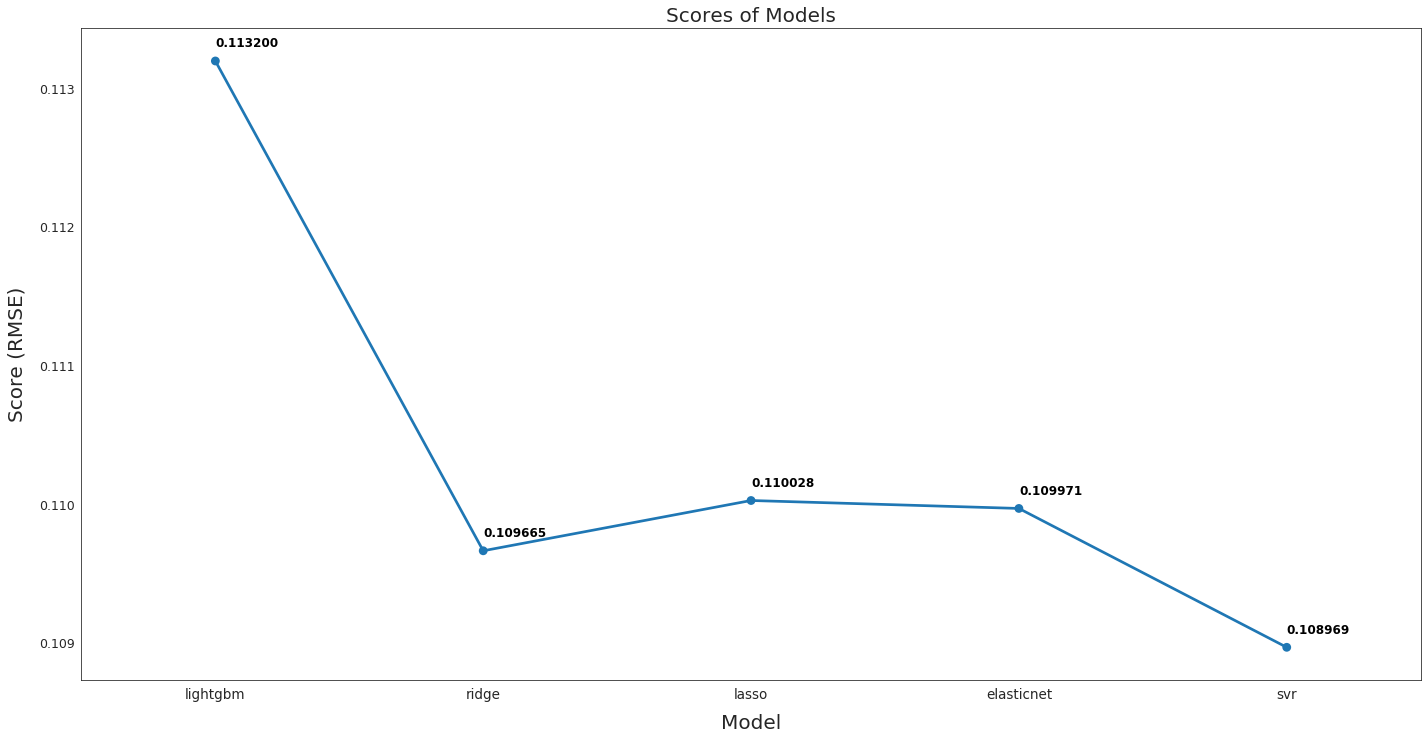

In [73]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0]+0.0001, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

## 12. Подберем оптимальные параметры для lightgbm

### Старая модель

In [0]:
# LightGBM 
old_lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=4,
                       learning_rate=0.01, 
                       n_estimators=9000,
                       max_bin=200, 
                       bagging_fraction=0.75,
                       bagging_freq=5, 
                       bagging_seed=7,
                       feature_fraction=0.2,
                       feature_fraction_seed=7,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

scores = {}
score = cv_rmse(old_lightgbm)
print("old lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['old lightgbm'] = (score.mean(), score.std())

old lightgbm: 0.1130 (0.0172)


### Подберем параметры при помощи использования GridSearch

In [0]:
from sklearn.model_selection import GridSearchCV
gridParams = {
    'learning_rate': [0.01, 0.0125],
    'n_estimators': [2000, 4500],
    'num_leaves': [2,3,4], # large num_leaves helps improve accuracy but might lead to over-fitting
        'objective' : ['regression'],
    'max_bin':[230, 255, 270], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [500],
    'bagging_fraction':[0.65],
                       'bagging_freq':[1,2,3,4], 
                       'bagging_seed':[2,3,4],
                       'feature_fraction':[0.2],
    'min_sum_hessian_in_leaf':[1,2,3,4,5]
                   
    }

grid = GridSearchCV(lightgbm, gridParams, verbose=1, cv=4, n_jobs=-1)
# Run the grid
grid.fit(X, y_train)

Fitting 4 folds for each of 2160 candidates, totalling 8640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 8640 out of 8640 | elapsed: 27.4min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=LGBMRegressor(bagging_fraction=0.75, bagging_freq=5,
                                     bagging_seed=7, boosting_type='gbdt',
                                     class_weight=None, colsample_bytree=1.0,
                                     feature_fraction=0.2,
                                     feature_fraction_seed=7,
                                     importance_type='split',
                                     learning_rate=0.01, max_bin=200,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     min_...
             param_grid={'bagging_fraction': [0.65],
                         'bagging_freq': [1, 2, 3, 4],
                         'bagging_seed': [2, 3, 4], 'feature_fraction': [0.2],
                         'learning_rate': [0.01, 0.0125],
                         'max_bin': [2

In [0]:
grid.best_params_

{'bagging_fraction': 0.65,
 'bagging_freq': 4,
 'bagging_seed': 2,
 'feature_fraction': 0.2,
 'learning_rate': 0.01,
 'max_bin': 255,
 'min_sum_hessian_in_leaf': 1,
 'n_estimators': 4500,
 'num_leaves': 4,
 'objective': 'regression',
 'random_state': 500}

### Новая модель с оптимальными параметрами

In [0]:
light_gbm = LGBMRegressor(objective='regression', 
                       num_leaves=4,
                       learning_rate=0.01, 
                       n_estimators=4500,
                       max_bin=255, 
                       bagging_fraction=0.65,
                       bagging_freq=4, 
                       bagging_seed=2,
                       feature_fraction=0.2,
                       min_sum_hessian_in_leaf = 1,
                       verbose=-1,
                       random_state=500)

In [0]:
score = cv_rmse(light_gbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lightgbm'] = (score.mean(), score.std())

lgb_model = light_gbm.fit(X, y_train)
submission=lgb_model.predict(X_test)

lightgbm: 0.1122 (0.0172)


In [0]:
submission = pd.read_csv("sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(submission))
submission.to_csv("submission_lgbm.csv", index=False)

### Результаты после подбора параметров

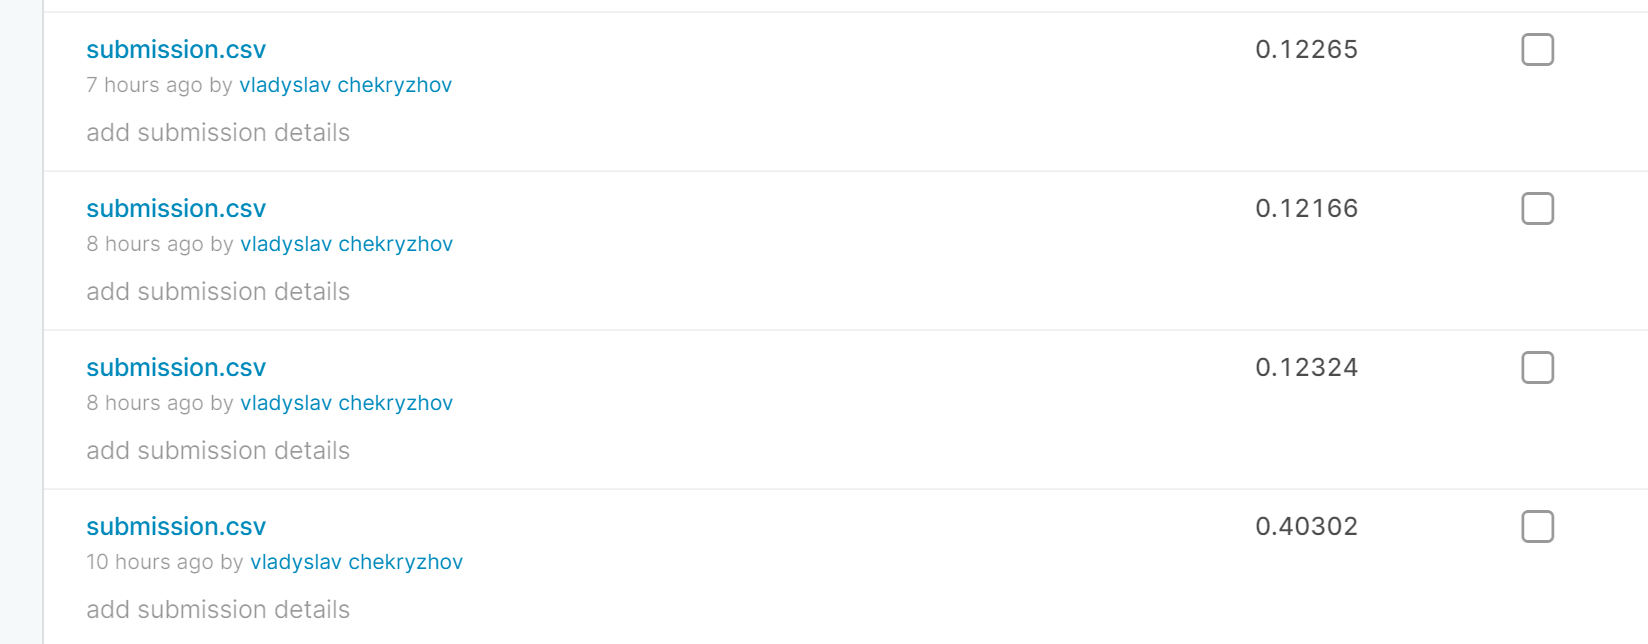

In [1]:
from IPython.display import Image 
Image("Score_sm_2.png") 

## 13. Обучение ансамбля моделей (Stacking)

In [41]:
print('----START Fit----',datetime.now())
print('Elasticnet')
elastic_model = elasticnet.fit(X, y_train)
print('Lasso')
lasso_model = lasso.fit(X, y_train)
print('Ridge')
ridge_model = ridge.fit(X, y_train)
print('lightgbm')
lgb_model = lightgbm.fit(X, y_train)
print('svr')
svr_model = svr.fit(X, y_train)

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y_train))

----START Fit---- 2020-02-26 19:18:34.347014
Elasticnet
Lasso
Ridge
lightgbm
svr
stack_gen


In [0]:
score = cv_rmse(stack_gen_model)
print("stack_gen_model: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['stack_gen_model'] = (score.mean(), score.std())

stack_gen_model: 0.1094 (0.0135)


## 14. Blending

In [62]:
def blend_predictions_1(X):
    return ((0.2  * elastic_model.predict(X)) + \
            (0.2 * lasso_model.predict(X)) + \
            (0.2 * ridge_model.predict(X)) + \
            (0.2 * lgb_model.predict(X)) + \
            (0.2 * svr_model.predict(X)))
    
blended_score = rmsle(y_train, blend_predictions_1(X))
scores['blended_1'] = (blended_score, 0)
print('RMSLE score on train data v1.0:')
print(blended_score)

RMSLE score on train data v1.0:
0.0848502241481767


In [63]:
def blend_predictions_2(X):
    return ((0.12  * elastic_model.predict(X)) + \
            (0.12 * lasso_model.predict(X)) + \
            (0.12 * ridge_model.predict(X)) + \
            (0.22 * lgb_model.predict(X)) + \
            (0.1 * svr_model.predict(X)) + \
            (0.32 * stack_gen_model.predict(np.array(X))))
    
blended_score = rmsle(y_train, blend_predictions_2(X))
scores['blended_2'] = (blended_score, 0)
print('RMSLE score on train data v2.0:')
print(blended_score)

RMSLE score on train data v2.0:
0.08772852185269664


In [64]:
def blend_predictions_3(X):
    return ((0.12  * elastic_model.predict(X)) + \
            (0.12 * lasso_model.predict(X)) + \
            (0.12 * ridge_model.predict(X)) + \
            (0.22 * lgb_model.predict(X)) + \
            (0.2 * svr_model.predict(X)) + \
            (0.22 * stack_gen_model.predict(np.array(X))))
    
blended_score = rmsle(y_train, blend_predictions_3(X))
scores['blended_3'] = (blended_score, 0)
print('RMSLE score on train data v3.0:')
print(blended_score)

RMSLE score on train data v3.0:
0.08624213443568941


In [66]:
def blend_predictions_4(X):
    return ((0.15  * elastic_model.predict(X)) + \
            (0.15 * lasso_model.predict(X)) + \
            (0.1 * ridge_model.predict(X)) + \
            (0.2 * lgb_model.predict(X)) + \
            (0.2 * svr_model.predict(X)) + \
            (0.2 * stack_gen_model.predict(np.array(X))))
    
blended_score = rmsle(y_train, blend_predictions_4(X))
scores['blended_4'] = (blended_score, 0)
print('RMSLE score on train data v4.0:')
print(blended_score)

RMSLE score on train data v4.0:
0.08662745189936931


## 15. Анализ результатов

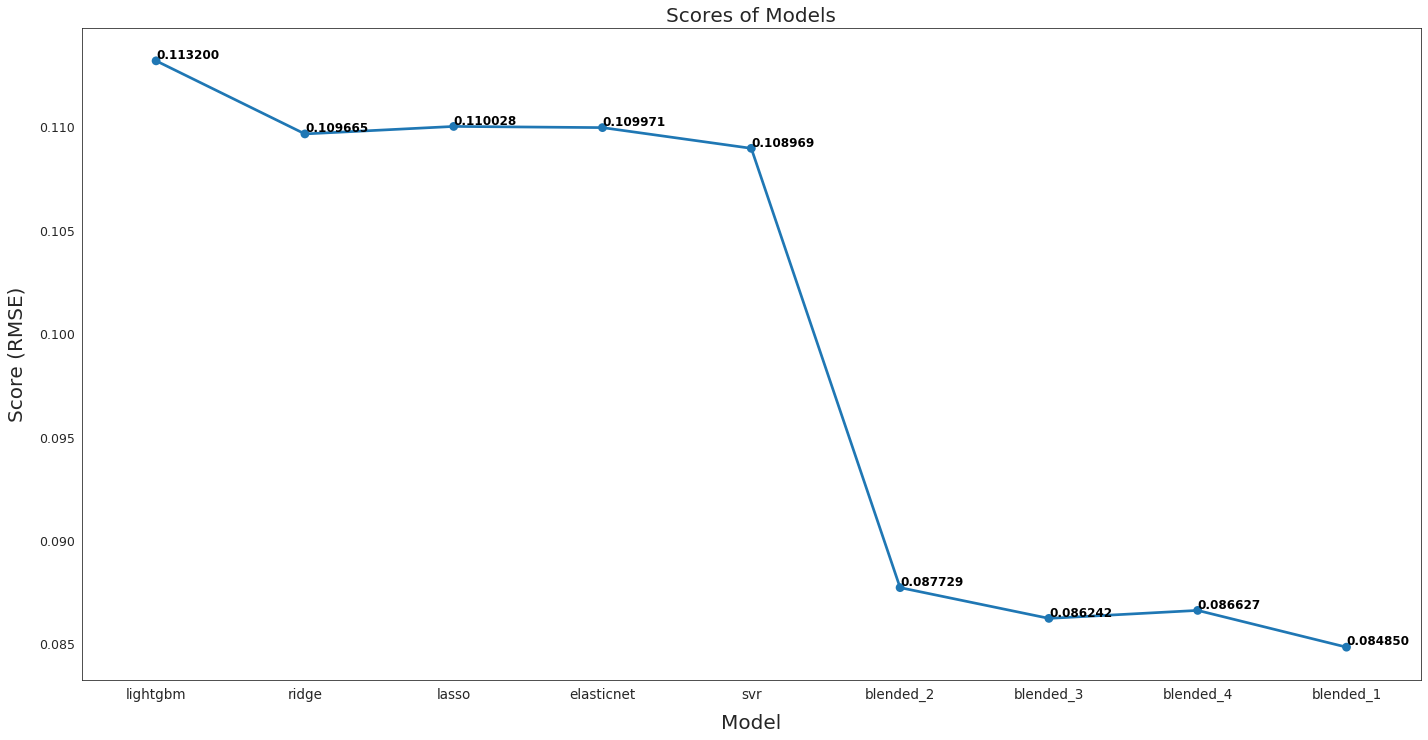

In [67]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.0001, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

Из результатов видно, что лучший результат показывает комбинация моделей. Ее и будем использовать для финальной записи результатов

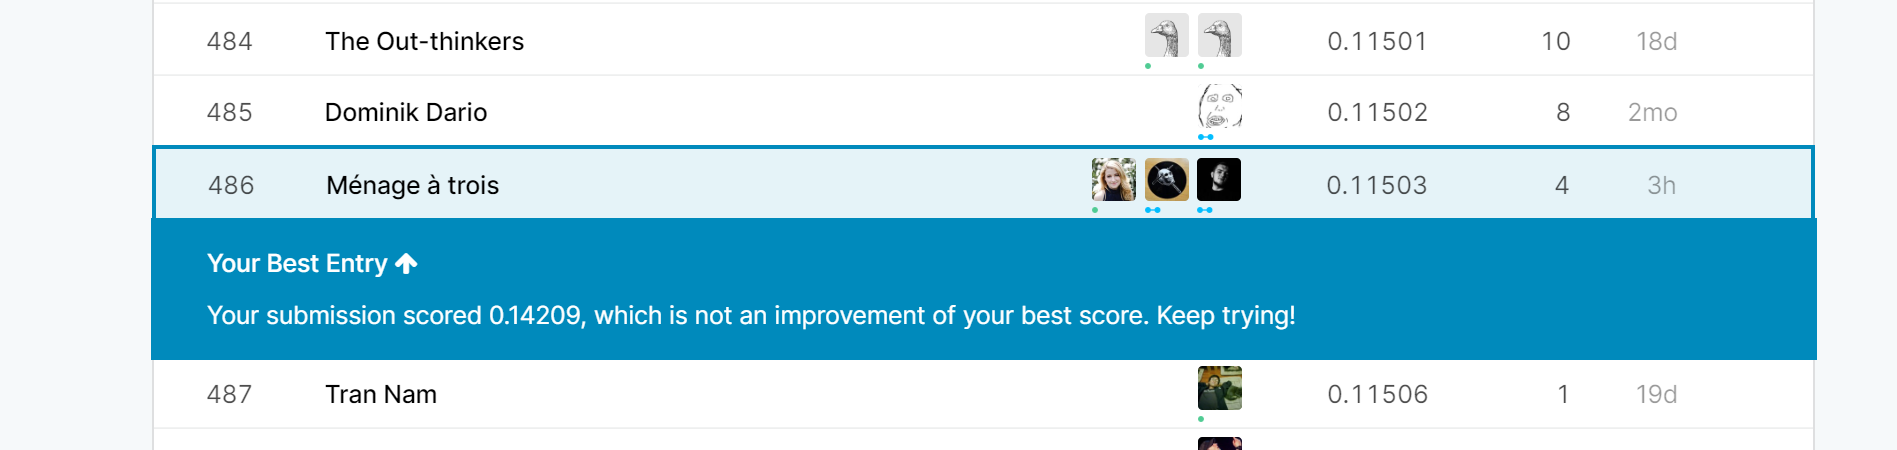

In [2]:
from IPython.display import Image 
Image("Score.png") 

## 16. Нейронная сеть

In [0]:
import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet import autograd

from scipy.stats import skew
from scipy.stats.stats import pearsonr

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

In [0]:
train_set = train

def get_rmse_log(net, X_train, y_train):
    num_train = X_train.shape[0]
    clipped_preds = nd.clip(net(X_train), 1, float('inf'))
    return nd.sqrt(2*nd.sum(square_loss(nd.log(clipped_preds),nd.log(y_train))/num_train)).asscalar()

# создание нейросети
def get_net():
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(128, activation='relu'))
        net.add(gluon.nn.Dropout(0.01))
        net.add(gluon.nn.Dense(1))
    net.initialize()
    return net

# обучение
def train(net, X_train, y_train, X_test, y_test, epochs,
          verbose_epoch, learning_rate, weight_decay):
    train_loss = []
    if X_test is not None:
        test_loss = []
    batch_size = 100
    dataset_train = gluon.data.ArrayDataset(X_train, y_train)
    data_iter_train = gluon.data.DataLoader(
        dataset_train, batch_size,shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': learning_rate,
                             'wd': weight_decay})
    net.collect_params().initialize(force_reinit=True)
    for epoch in range(epochs):
        for data, label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)

            cur_train_loss = get_rmse_log(net, X_train, y_train)
        if epoch > verbose_epoch:
            print("Epoch %d, train loss: %f" % (epoch, cur_train_loss))
        train_loss.append(cur_train_loss)
        if X_test is not None:
            cur_test_loss = get_rmse_log(net, X_test, y_test)
            test_loss.append(cur_test_loss)
    plt.plot(train_loss)
    plt.legend(['train'])
    if X_test is not None:
        plt.plot(test_loss)
        plt.legend(['train','test'])
    plt.show()
    if X_test is not None:
        return cur_train_loss, cur_test_loss
    else:
        return cur_train_loss
    
# кросс-валидация
def k_fold_cross_valid(k, epochs, verbose_epoch, X_train, y_train,
                       learning_rate, weight_decay):
    assert k > 1
    fold_size = X_train.shape[0] // k
    train_loss_sum = 0.0
    test_loss_sum = 0.0
    for test_i in range(k):
        X_val_test = X_train[test_i * fold_size: (test_i + 1) * fold_size, :]
        y_val_test = y_train[test_i * fold_size: (test_i + 1) * fold_size]

        val_train_defined = False
        for i in range(k):
            if i != test_i:
                X_cur_fold = X_train[i * fold_size: (i + 1) * fold_size, :]
                y_cur_fold = y_train[i * fold_size: (i + 1) * fold_size]
                if not val_train_defined:
                    X_val_train = X_cur_fold
                    y_val_train = y_cur_fold
                    val_train_defined = True
                else:
                    X_val_train = nd.concat(X_val_train, X_cur_fold, dim=0)
                    y_val_train = nd.concat(y_val_train, y_cur_fold, dim=0)
        net = get_net()
        train_loss, test_loss = train(
            net, X_val_train, y_val_train, X_val_test, y_val_test,epochs, verbose_epoch, learning_rate, weight_decay)
        train_loss_sum += train_loss
        print("Test loss: %f" % test_loss)
        test_loss_sum += test_loss
    return train_loss_sum / k, test_loss_sum / k

# предсказание при помощи сети
def learn(epochs, verbose_epoch, X_train, y_train, test, learning_rate,
          weight_decay):
    net = get_net()
    train(net, X_train, y_train, None, None, epochs, verbose_epoch,
          learning_rate, weight_decay)
    preds = net(X_test).asnumpy()
    test['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_id, test['SalePrice']], axis=1)
    submission.to_csv('submission_222.csv', index=False)

Epoch 36, train loss: 0.101352
Epoch 37, train loss: 0.100868
Epoch 38, train loss: 0.100435
Epoch 39, train loss: 0.099642


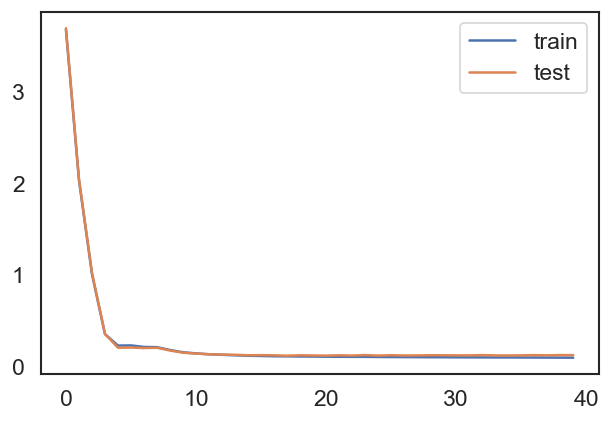

Test loss: 0.127304
Epoch 36, train loss: 0.099523
Epoch 37, train loss: 0.098961
Epoch 38, train loss: 0.098720
Epoch 39, train loss: 0.098635


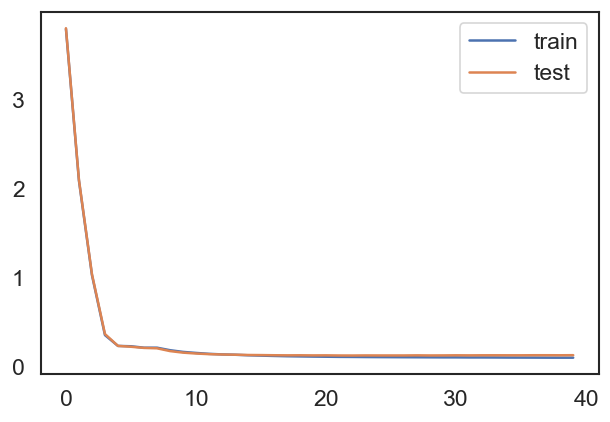

Test loss: 0.126863
Epoch 36, train loss: 0.096196
Epoch 37, train loss: 0.096005
Epoch 38, train loss: 0.095730
Epoch 39, train loss: 0.095629


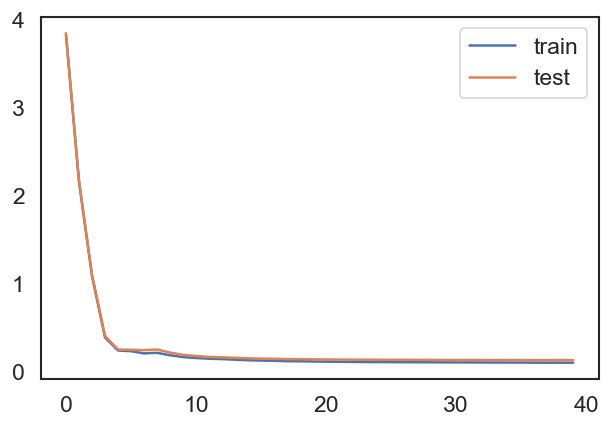

Test loss: 0.125298
Epoch 36, train loss: 0.102531
Epoch 37, train loss: 0.102209
Epoch 38, train loss: 0.102197
Epoch 39, train loss: 0.101533


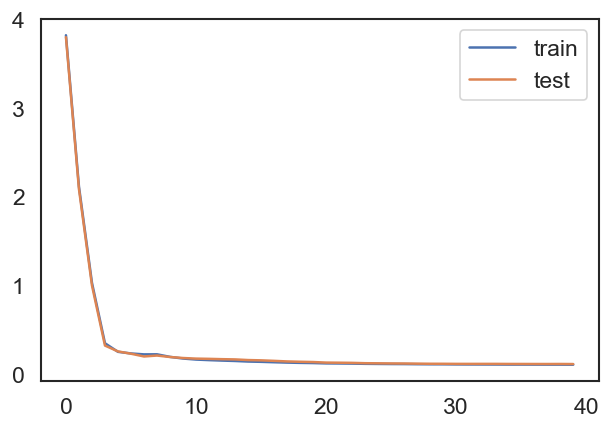

Test loss: 0.108691
Epoch 36, train loss: 0.098439
Epoch 37, train loss: 0.098348
Epoch 38, train loss: 0.097990
Epoch 39, train loss: 0.098017


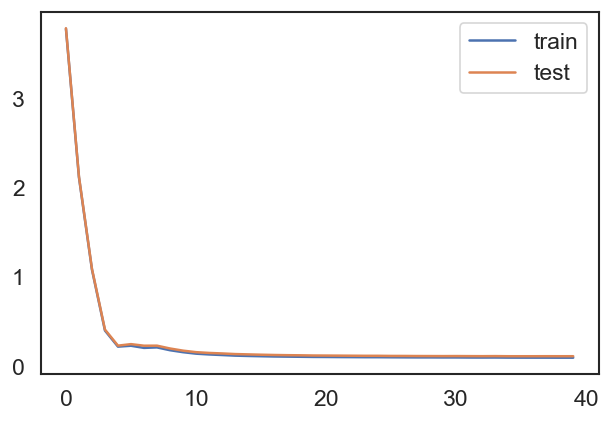

Test loss: 0.114516
5d-fold validation: Avg train loss: 0.09869133830070495, Avg test loss: 0.12053434103727341


In [0]:
# предобработка данных для сети
train_len = len(train_set)
df = all_features
numnic_feats = df.dtypes[df.dtypes!='object'].index
df[numnic_feats] = df[numnic_feats].apply(lambda x: (x-x.mean())/x.std())
df = pd.get_dummies(df).reset_index(drop=True)

num_train = train_set.shape[0]
X_train = df[:num_train].as_matrix()
X_test = df[num_train:].as_matrix()

X_train = nd.array(X_train)
y_train = nd.array(y_train_old)
y_train.reshape((num_train, 1))

X_test = nd.array(X_test)
square_loss = gluon.loss.L2Loss()

# зададим параметры сети
k = 5
epochs = 40
verbose_epoch = 35
learning_rate = 0.1 
weight_decay = 130 

# обучим сеть
train_loss, test_loss = k_fold_cross_valid(k, epochs, verbose_epoch, X_train, y_train, learning_rate, weight_decay)
print("{}d-fold validation: Avg train loss: {}, Avg test loss: {}".format(k, train_loss, test_loss))

Epoch 36, train loss: 0.101314
Epoch 37, train loss: 0.101242
Epoch 38, train loss: 0.101099
Epoch 39, train loss: 0.101021


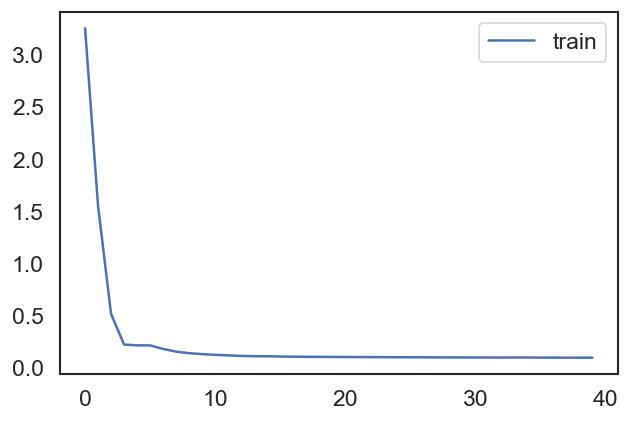

In [0]:
# проскорим выборку при помощи сети   
learn(epochs, verbose_epoch, X_train, y_train, test, learning_rate, weight_decay)

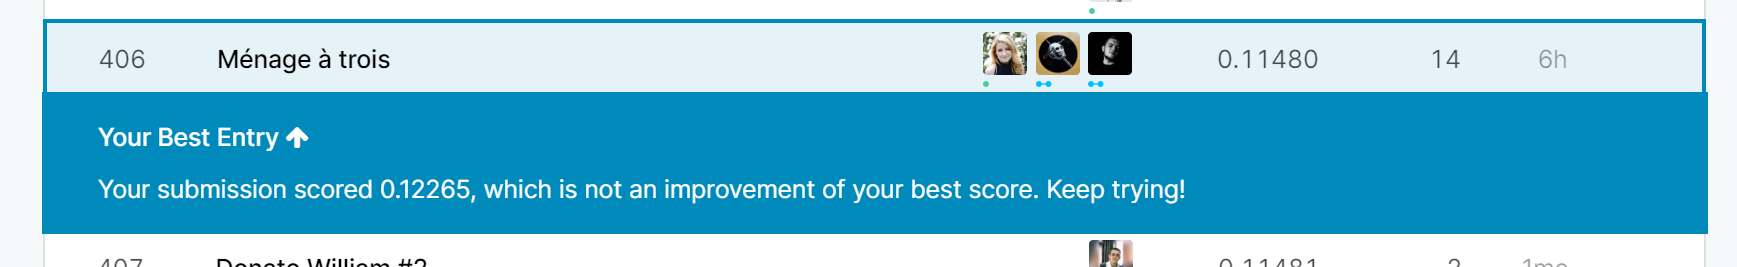

In [4]:
from IPython.display import Image 
Image("Score_nn.png") 

Применение нейросети на EDA-датасете позволило улучшить результаты на 227 позиций.

## 17. Финальная позиция на табло результатов

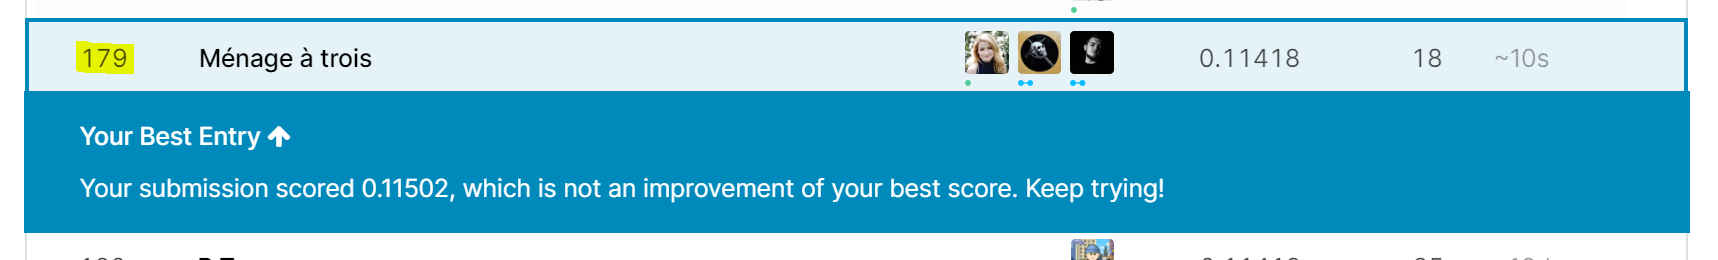

In [3]:
from IPython.display import Image 
Image("score_nn_eda.png") 